In [1]:
import pandas as pd
import django, sys, os
sys.path.append('/home/max/software/django-tmv/tmv_mcc-apsis/BasicBrowser')
os.environ.setdefault("DJANGO_SETTINGS_MODULE", "BasicBrowser.settings")
django.setup()
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.neural_network import MLPClassifier
import numpy as np
import matplotlib.pyplot as plt
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from utils.text import *
from scoping.models import *
import scoping.utils.learning_utils as lu

p = Project.objects.get(pk=178)
p

<Project: Regional Impacts Map>

In [2]:
df = pd.read_csv('../data/doctables/all_relevance.csv')
print(df.shape)
seen_index = df[df['seen']==1].index
unseen_index = df[df['seen']==0].index
unseen_sample = unseen_index[random.sample(range(len(unseen_index)),10000)]
df = df.loc[list(unseen_sample.union(seen_index)),:].reset_index(drop=True) 
#df = df.loc[list(seen_index),:]  

seen_index = df[df['seen']==1].index
unseen_index = df[df['seen']==0].index
print(df.shape)
df.head()
df.head()

(378365, 9)
(11913, 9)


,id,content,title,wosarticle__de,wosarticle__wc,ar5,seen,relevant,16 - Future/modelled impacts
0,222401,Sea-level rise and frequent intense hurricanes...,Purple Pitcher Plant (Sarracenia rosea) Diebac...,0,['Multidisciplinary Sciences'],0.0,0.0,0.0,0.0
1,609659,The first step to reduce greenhouse gas emissi...,Calculating green house gas emissions for buil...,carbon calculating tools; low carbon architect...,['Construction & Building Technology'],0.0,0.0,0.0,0.0
2,257099,Two decades of drought and rising temperatures...,Structural and regenerative changes in old-gro...,Pinon; Juniper; Beetle-kill; Fuel and fire beh...,['Forestry'],0.0,0.0,0.0,0.0
3,2364962,The objective of this study was to evaluate th...,Effect of sex on productive performance and ch...,Cobb 500 (R); feed conversion; female; male; m...,['Agronomy'],0.0,0.0,0.0,0.0
4,99895,Climatic variability in dryland production env...,Crop design for specific adaptation in variabl...,crop improvement; crop modelling; G x E; genot...,"['Agriculture, Multidisciplinary']",0.0,0.0,0.0,0.0


In [3]:
vec = TfidfVectorizer(
    ngram_range=(1,2),
    min_df=4, max_df=0.8, strip_accents='unicode', 
    max_features=20000,
    tokenizer=snowball_stemmer(),
    #sublinear_tf=True
)

X = vec.fit_transform(df['content'].astype("str"))#+" " + df['title'].astype("str"))   

KeyboardInterrupt: 

In [ ]:
fig, ax = plt.subplots()
n = df.query('seen==1').shape[0]
y = df['relevant']
for i, (name, group) in enumerate(df.query('seen==1').groupby('relevant')):
    ax.bar(i, group.shape[0])
    ax.text(i, group.shape[0]+n*0.02, f'{group.shape[0]/n:.0%}',ha="center")

ax.set_xticks([0,1])
ax.set_ylim(ymax=ax.get_ylim()[1]*1.05)
ax.set_xlabel('Relevance')
ax.set_ylabel('Number of documents')

In [ ]:
from sklearn.model_selection import KFold

y = df['relevant']
clf_models = [
    {
        'title': 'SVM', 
        'model': SVC(kernel='linear',class_weight='balanced',probability=True)
    },
    {
        'title':"Neural Net",
        'model': MLPClassifier(
            solver='lbfgs', 
            alpha=0.1,
            hidden_layer_sizes=(10), 
            random_state=1
        )
    },
    {
        'title': 'Naive Bayes', 
        'model': MultinomialNB(alpha=0.1)     
    }
]

clf_models = lu.cross_validate_models(X, y, clf_models, seen_index)

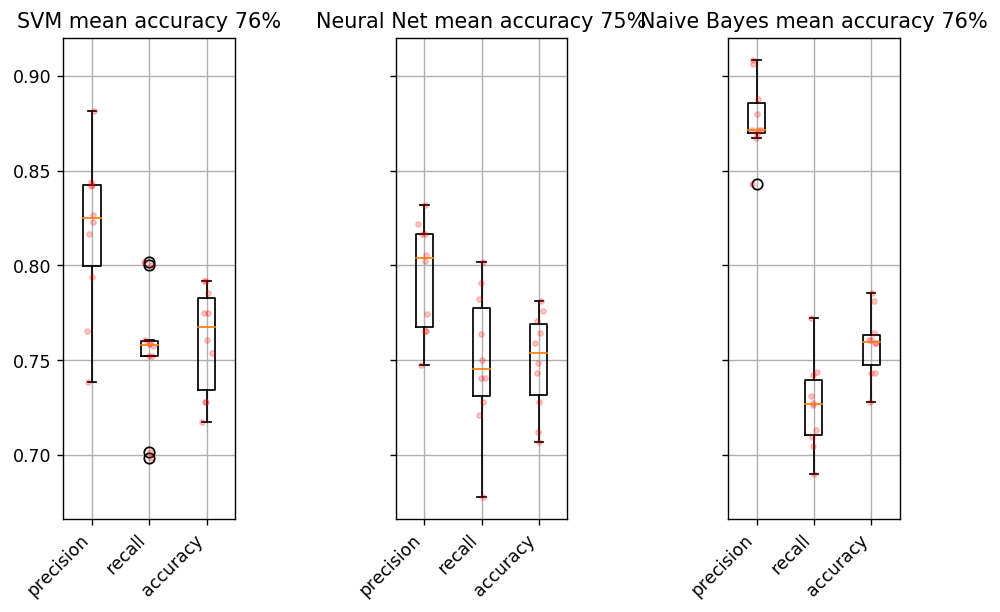

In [15]:
fig, axs = plt.subplots(1, len(clf_models),dpi=125,figsize=(8,5),sharey=True)              
lu.plot_model_output(clf_models,  ['p','r','e'], fig, axs)
for ax in axs:
    ax.set_xticklabels(["precision","recall","accuracy"])
fig.tight_layout()

In [19]:
from importlib import reload  
reload(scoping.utils.learning_utils)

from sklearn.model_selection import KFold

y = df['relevant']
clf_models = [
    {
        'title': 'SVM', 
        'model': SVC(kernel='linear',class_weight='balanced',probability=True)
    },
]

clf_models, df = lu.cross_validate_models(X, y, clf_models, seen_index, n_splits=5, df=df)

1
2
3
4
5


In [21]:
django.db.connection.close()
fn = df[(df["relevant"]==1) & (df[f'y_k_prediction']<0.5)]
print(fn.shape)
for i, row in fn.head(5).iterrows():
    d = Doc.objects.get(pk=row['id'])
    print(row['title'])
    print(row['content'])
    print(row[c])
    print(d.docusercat_set.values('category__name'))
    for c in df.columns:
        if "k_prediction" in c:
            print(c)
            print(row[c])

(193, 10)
Mangrove forests: Resilience, protection from tsunamis, and responses to global climate change
This review assesses the degree of resilience of mangrove forests to large, infrequent disturbance (tsunamis) and their role in coastal protection, and to chronic disturbance events (climate change) and the future of mangroves in the face of global change. From a geological perspective, mangroves come and go at considerable speed with the current distribution of forests a legacy of the Holocene, having undergone almost chronic disturbance as it result of fluctuations in sea-level. Mangroves have demonstrated considerable resilience over timescales commensurate with shoreline evolution. This notion is supported by evidence that soil accretion rates in mangrove forests are currently keeping pace with mean sea-level rise. Further support for their resilience comes from patterns of recovery from natural disturbances (storms, hurricanes) which coupled with key life history traits, sugges

NameError: name 'c' is not defined

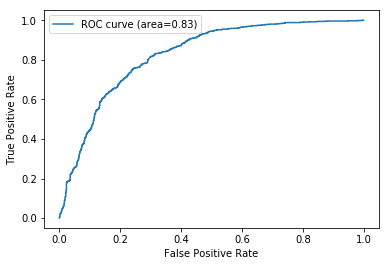

In [30]:
from sklearn.metrics import roc_curve, roc_auc_score, auc
pdf = df.query('seen==1')
fpr, tpr, _ = roc_curve(pdf['relevant'],pdf['y_k_prediction'])
roc_auc = auc(fpr, tpr)
plt.plot(fpr,tpr, label=f"ROC curve (area={roc_auc:.2f})")
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

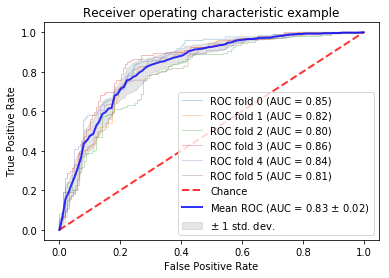

In [17]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import plot_roc_curve, auc
from scipy import interp
import sklearn.metrics
from sklearn.metrics import precision_score, recall_score, r2_score

cv = StratifiedKFold(n_splits=6)
classifier = SVC(kernel='linear',class_weight='balanced',probability=True)

tprs = []
aucs = []
es = []
f1s = []
ps = []
rs = []
mean_fpr = np.linspace(0, 1, 100)

fig, ax = plt.subplots()
for i, (train, test) in enumerate(cv.split(X[seen_index], y[seen_index])):
    train = seen_index[train]
    test = seen_index[test]
    classifier.fit(X[train], y[train])
    y_true = y[test]
    y_pred_bin = classifier.predict(X[test])
    y_pred = classifier.predict_proba(X[test])[:,1]
    es.append(sklearn.metrics.accuracy_score(y_true, y_pred_bin))
    f1s.append(sklearn.metrics.f1_score(y_true, y_pred_bin))
    ps.append(sklearn.metrics.precision_score(y_true, y_pred_bin))
    rs.append(sklearn.metrics.recall_score(y_true, y_pred_bin))
    
    viz = plot_roc_curve(classifier, X[test], y[test],
                         name='ROC fold {}'.format(i),
                         alpha=0.3, lw=1, ax=ax)
    interp_tpr = interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='b',
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                label=r'$\pm$ 1 std. dev.')

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="Receiver operating characteristic example")
ax.legend(loc="lower right")
plt.show()

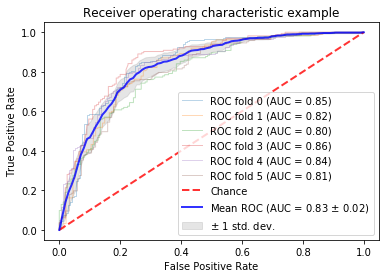

In [27]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import plot_roc_curve, auc
from scipy import interp
import sklearn.metrics
from sklearn.metrics import precision_score, recall_score, r2_score

cv = KFold(n_splits=6)
classifier = SVC(kernel='linear',class_weight='balanced',probability=True)

tprs = []
aucs = []
es = []
f1s = []
ps = []
rs = []
mean_fpr = np.linspace(0, 1, 100)

fig, ax = plt.subplots()
for i, (train, test) in enumerate(cv.split(X[seen_index], y[seen_index])):
    train = seen_index[train]
    test = seen_index[test]
    classifier.fit(X[train], y[train])
    y_true = y[test]
    y_pred_bin = classifier.predict(X[test])
    y_pred = classifier.predict_proba(X[test])[:,1]
    es.append(sklearn.metrics.accuracy_score(y_true, y_pred_bin))
    f1s.append(sklearn.metrics.f1_score(y_true, y_pred_bin))
    ps.append(sklearn.metrics.precision_score(y_true, y_pred_bin))
    rs.append(sklearn.metrics.recall_score(y_true, y_pred_bin))
    
    viz = plot_roc_curve(classifier, X[test], y[test],
                         name='ROC fold {}'.format(i),
                         alpha=0.3, lw=1, ax=ax)
    interp_tpr = interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='b',
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                label=r'$\pm$ 1 std. dev.')

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="Receiver operating characteristic example")
ax.legend(loc="lower right")
plt.show()